In [26]:
import numpy as np 
import pandas as pd 

In [27]:
filepath = "D:\\test002.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close
6,2018-1-10,575.0,576.5,566.0,571.0
7,2018-1-11,572.5,573.5,564.5,570.0
8,2018-1-12,569.5,570.5,551.5,558.0
9,2018-1-15,556.0,560.0,548.0,553.5
10,2018-1-16,555.0,562.0,545.5,548.0


In [28]:
data.shape

(730, 5)

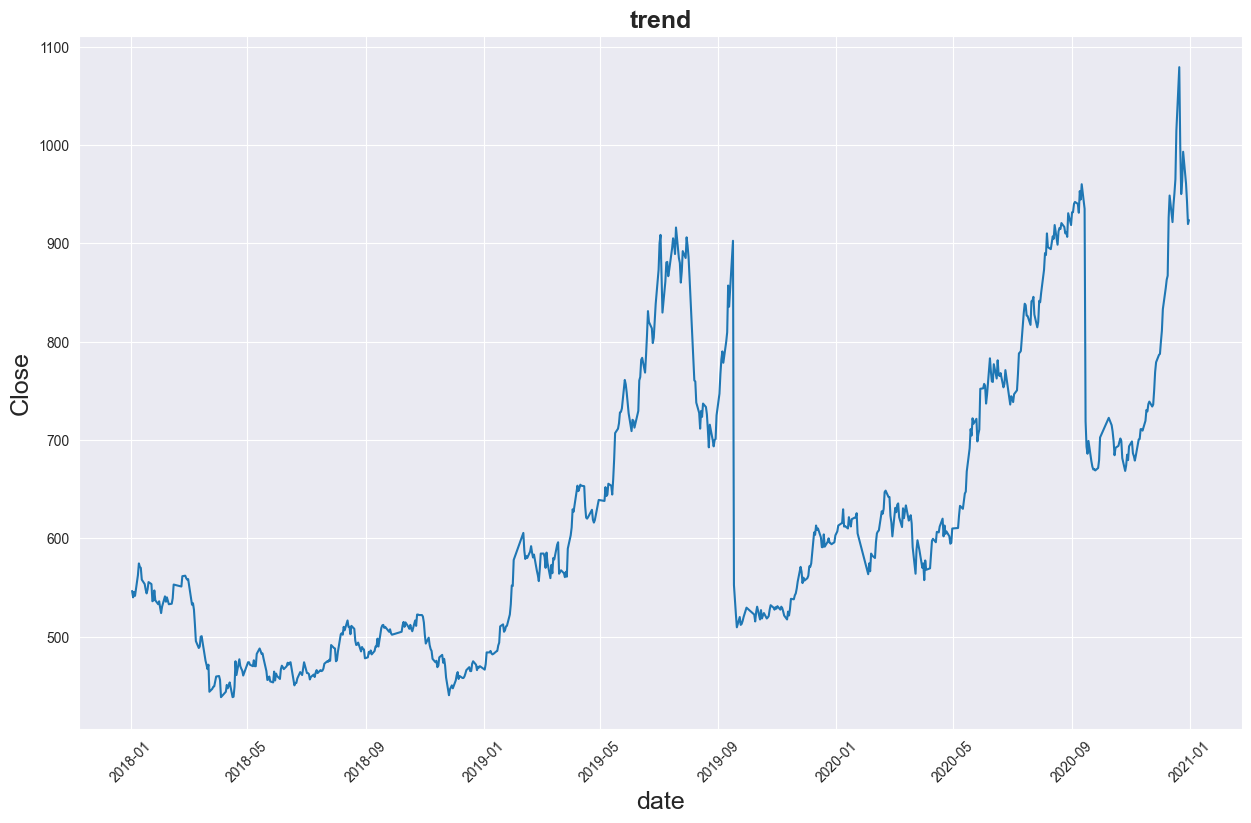

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 从CSV文件中读取数据
data = pd.read_csv(filepath)

# 转换日期列为日期类型
data['Date'] = pd.to_datetime(data['Date'])

# 转换收盘价列为浮点数类型
data['Close'] = data['Close'].astype(float)

# 提取需要绘制的列数据
x = data['Date']
y = data['Close']

# 绘制折线图

plt.figure(figsize = (15,9))
plt.title('trend',fontsize=18, fontweight='bold')
plt.xlabel('date',fontsize=18)
plt.ylabel('Close',fontsize=18)
# 设置x轴刻度
plt.xticks(rotation=45)
plt.plot(x, y)

# 显示图形
plt.show()#


# 1. 特征工程

In [30]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   730 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

C:\Users\李德杰\AppData\Local\Temp\ipykernel_2836\68737012.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
price['Close']

0     -0.662763
1     -0.683060
2     -0.665886
3     -0.678376
4     -0.612802
         ...   
725    0.731460
726    0.629977
727    0.573770
728    0.501952
729    0.514442
Name: Close, Length: 730, dtype: float64

# 2. 数据集制作

In [33]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    data = []
    
    # you can free play（seq_length）
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [34]:
lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (568, 19, 1)
y_train.shape =  (568, 1)
x_test.shape =  (142, 19, 1)
y_test.shape =  (142, 1)


注意：pytorch的nn.LSTM input shape=(seq_length, batch_size, input_size)

# 3. 模型构建 —— LSTM

In [35]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [36]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs =300

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [38]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# 4. 模型训练

In [39]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.6185528039932251
Epoch  1 MSE:  0.41208529472351074
Epoch  2 MSE:  0.2417467087507248
Epoch  3 MSE:  0.10936976224184036
Epoch  4 MSE:  0.2515021860599518
Epoch  5 MSE:  0.14627216756343842
Epoch  6 MSE:  0.09607947617769241
Epoch  7 MSE:  0.10983681678771973
Epoch  8 MSE:  0.12803450226783752
Epoch  9 MSE:  0.1326720267534256
Epoch  10 MSE:  0.12365064769983292
Epoch  11 MSE:  0.1052667647600174
Epoch  12 MSE:  0.08375688642263412
Epoch  13 MSE:  0.06750189512968063
Epoch  14 MSE:  0.0645994320511818
Epoch  15 MSE:  0.07289405912160873
Epoch  16 MSE:  0.07299283146858215
Epoch  17 MSE:  0.05617624148726463
Epoch  18 MSE:  0.036276426166296005
Epoch  19 MSE:  0.02629881165921688
Epoch  20 MSE:  0.02869308553636074
Epoch  21 MSE:  0.03631297126412392
Epoch  22 MSE:  0.03404902294278145
Epoch  23 MSE:  0.021910138428211212
Epoch  24 MSE:  0.01860964298248291
Epoch  25 MSE:  0.026559678837656975
Epoch  26 MSE:  0.0274079330265522
Epoch  27 MSE:  0.01905878819525242
Epoch 

Epoch  32 MSE:  0.018182510510087013
Epoch  33 MSE:  0.014693434350192547
Epoch  34 MSE:  0.012574190273880959
Epoch  35 MSE:  0.013270552270114422
Epoch  36 MSE:  0.015026628039777279
Epoch  37 MSE:  0.01470201276242733
Epoch  38 MSE:  0.012165657244622707
Epoch  39 MSE:  0.010297708213329315
Epoch  40 MSE:  0.010711929760873318
Epoch  41 MSE:  0.012070603668689728
Epoch  42 MSE:  0.012297605164349079
Epoch  43 MSE:  0.01102442853152752
Epoch  44 MSE:  0.00973396934568882
Epoch  45 MSE:  0.00979161448776722
Epoch  46 MSE:  0.010609876364469528
Epoch  47 MSE:  0.010578127577900887
Epoch  48 MSE:  0.009552679024636745
Epoch  49 MSE:  0.008788222447037697
Epoch  50 MSE:  0.008899497799575329
Epoch  51 MSE:  0.009309167042374611
Epoch  52 MSE:  0.009291509166359901
Epoch  53 MSE:  0.008802236057817936
Epoch  54 MSE:  0.008350575342774391
Epoch  55 MSE:  0.008320259861648083
Epoch  56 MSE:  0.00852241925895214
Epoch  57 MSE:  0.008490306325256824
Epoch  58 MSE:  0.008127320557832718
Epoch 

# 5. 模型结果可视化

In [40]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

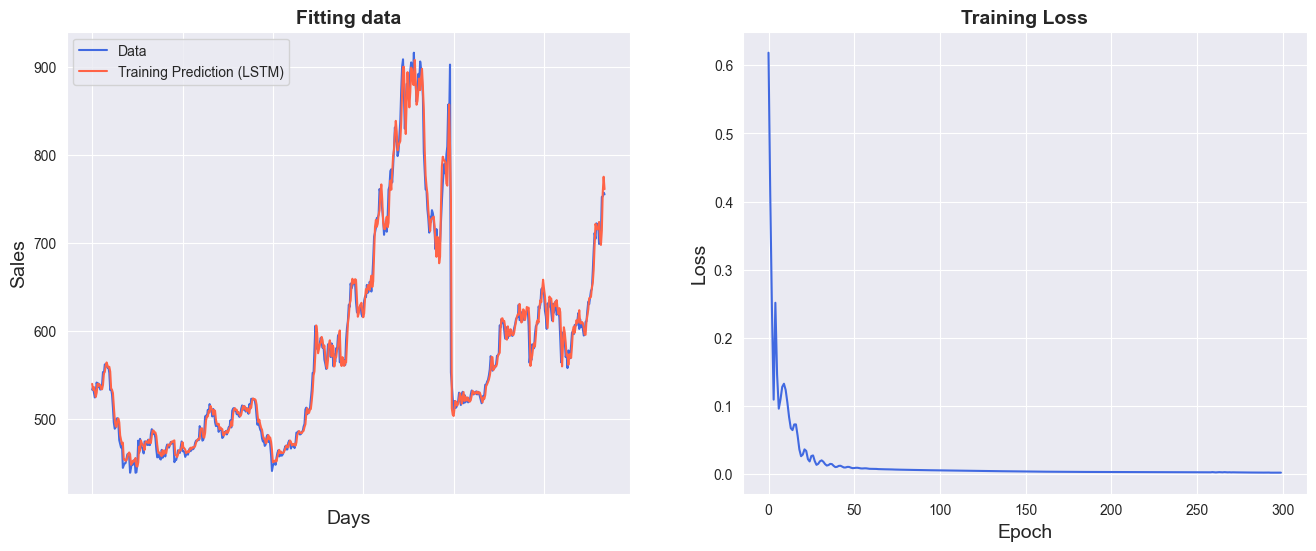

In [41]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Fitting data', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Sales", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

# 6. 模型验证

In [42]:
x_test[-1]

tensor([[0.1632],
        [0.2319],
        [0.2990],
        [0.3255],
        [0.3380],
        [0.5222],
        [0.5925],
        [0.5082],
        [0.5628],
        [0.6003],
        [0.6440],
        [0.7986],
        [1.0000],
        [0.7502],
        [0.5972],
        [0.6378],
        [0.7315],
        [0.6300],
        [0.5738]])

In [43]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = mean_squared_error(y_train[:,0], y_train_pred[:,0])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test[:,0], y_test_pred[:,0])
print('Test Score: %.2f MSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 220.81 MSE
Test Score: 948.94 MSE


In [44]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [47]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
#fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                   #mode='lines',
                   #name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='black',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='black',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
    ),
    showlegend=True,
    template = 'plotly_white'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()